# Pseudobulk differential expression to compare pGL2-BRI1-GFP/bri1-T to WT

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualizati

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/tmn23/miniconda3/envs/muscat/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] future_1.31.0               scran_1.26.0               
 [3] scuttle_1.8.0               SingleCellExperiment_1.20.0
 [5] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [7] GenomicRanges_1.50.0        GenomeInfoDb_1.34.8        
 [9]

In [4]:
rc.integrated <- readRDS("../../CheWei/scRNA-seq/Integrated_Objects/rc.integrated_6S_GL2_lines_seu4_annotated_20240429.rds")

In [5]:
rc.integrated

An object of class Seurat 
71741 features across 37615 samples within 3 assays 
Active assay: SCT (24847 features, 0 variable features)
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: pca, umap, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [6]:
feature_names <- read_tsv("../data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()

Rows: 32833 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): AGI, Name, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
table(rc.integrated$geno)


                  WT               bri1_T pGL2_BRI1_GFP_bri1_T 
               14493                12633                10489 

In [8]:
table(rc.integrated$geno, rc.integrated$orig.ident)

                      
                       sc_130 sc_131 sc_133 sc_134 sc_135 sc_137
  WT                     6656      0      0   7837      0      0
  bri1_T                    0   7658      0      0   4975      0
  pGL2_BRI1_GFP_bri1_T      0      0   8424      0      0   2065

In [9]:
table(rc.integrated$geno)


                  WT               bri1_T pGL2_BRI1_GFP_bri1_T 
               14493                12633                10489 

# Differential State Analysis with Muscat

In [10]:
#  samples you want to compare

integrated.de <- rc.integrated
integrated.de$genotype <- integrated.de$geno

In [11]:
integrated.de

An object of class Seurat 
71741 features across 37615 samples within 3 assays 
Active assay: SCT (24847 features, 0 variable features)
 2 other assays present: RNA, integrated
 3 dimensional reductions calculated: pca, umap, umap_2D

## Convert to sce

In [12]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$orig.ident,
                              group_id = integrated.de$genotype,
                              cluster_id = integrated.de$cell_type, 
                             rep=integrated.de$rep) # include experimental rep as co-variate

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [13]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 29697 37615 
metadata(1): experiment_info
assays(1): counts
rownames(29697): AT1G01010 AT1G01020 ... AT5G09785 ATCG00100
rowData names(0):
colnames(37615): AAACCCACAACAGCCC_4 AAACCCACAGAGTAAT_4 ...
  TTTGGTTTCTGGGCCA_9 TTTGGTTTCTTCACAT_9
colData names(4): cluster_id sample_id group_id rep
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## pre-filtering

In [14]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 27319 37615

In [15]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 23235 37615

In [16]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Columella"        "Lateral Root Cap" "Atrichoblast"     "Trichoblast"     
 [5] "Cortex"           "Endodermis"       "Phloem"           "Xylem"           
 [9] "Procambium"       "Pericycle"

In [17]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
sc_130,65,92,20,14,1823,3
sc_131,46,88,9,20,1088,5
sc_133,45,72,13,18,808,3
sc_134,44,73,16,18,1204,4
sc_135,14,52,10,15,617,3
sc_137,63,86,48,25,702,9


In [18]:
# metadata to manually add to DE contrast
bscs <- read.csv("../data/Benfey_single_cell_20230703.csv", na.strings=c("","NA"), stringsAsFactors = F)
bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)

In [19]:
# experiment info for contrasts, add rep from csv

ei <- metadata(sce)$experiment_info
ei

sample_date <- select(bscs, sample_id=sample, rep=rep)

ei <- left_join(ei, sample_date)

ei

sample_id,group_id,n_cells
<fct>,<fct>,<dbl>
sc_130,WT,6656
sc_134,WT,7837
sc_131,bri1_T,7658
sc_135,bri1_T,4975
sc_133,pGL2_BRI1_GFP_bri1_T,8424
sc_137,pGL2_BRI1_GFP_bri1_T,2065


Joining with `by = join_by(sample_id)`


sample_id,group_id,n_cells,rep
<chr>,<fct>,<dbl>,<chr>
sc_130,WT,6656,1
sc_134,WT,7837,2
sc_131,bri1_T,7658,1
sc_135,bri1_T,4975,2
sc_133,pGL2_BRI1_GFP_bri1_T,8424,1
sc_137,pGL2_BRI1_GFP_bri1_T,2065,2


In [20]:
mm <- model.matrix(~ 0 + ei$group_id + ei$rep)
dimnames(mm) <- list(ei$sample_id, c(levels(ei$group_id), "rep"))

mm

,WT,bri1_T,pGL2_BRI1_GFP_bri1_T,rep
sc_130,1,0,0,0
sc_134,1,0,0,1
sc_131,0,1,0,0
sc_135,0,1,0,1
sc_133,0,0,1,0
sc_137,0,0,1,1


In [21]:
contrast <- makeContrasts("pGL2_BRI1_GFP_bri1_T-WT",
                          "pGL2_BRI1_GFP_bri1_T-bri1_T",
                          levels = mm)

contrast

,pGL2_BRI1_GFP_bri1_T-WT,pGL2_BRI1_GFP_bri1_T-bri1_T
WT,-1,0
bri1_T,0,-1
pGL2_BRI1_GFP_bri1_T,1,1
rep,0,0


In [22]:
res <- pbDS(pb, design = mm, 
            contrast = contrast, 
            method="edgeR", 
            min_cells=5, 
            filter = c("none"))

  |======================================================================| 100%



### DEG results

In [23]:
# DEG results with gene freqs
(res_to_write_frq <- resDS(sce, res, bind = "row", cpm=TRUE, frq=T))

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_131.cpm,sc_135.cpm,sc_133.cpm,sc_137.cpm,sc_130.frq,sc_134.frq,⋯,WT.frq,bri1_T.frq,pGL2_BRI1_GFP_bri1_T.frq,logFC,logCPM,F,p_val,p_adj.loc,p_adj.glb,contrast
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AT1G01010,Columella,9.970,9.460,8.460,4.710,9.830,12.700,0.06940,0.0646,⋯,0.06750,0.06170,0.10000,0.2250,3.2900,0.51600,0.477000,0.81900,0.75800,pGL2_BRI1_GFP_bri1_T-WT
AT1G01010,Columella,9.970,9.460,8.460,4.710,9.830,12.700,0.06940,0.0646,⋯,0.06750,0.06170,0.10000,0.7410,3.2900,4.85000,0.034100,0.29500,0.25700,pGL2_BRI1_GFP_bri1_T-bri1_T
AT1G01020,Columella,14.100,15.700,16.200,17.500,15.700,17.400,0.09180,0.1020,⋯,0.09590,0.12900,0.12900,0.1520,4.0400,0.31900,0.576000,0.84400,0.81500,pGL2_BRI1_GFP_bri1_T-WT
AT1G01020,Columella,14.100,15.700,16.200,17.500,15.700,17.400,0.09180,0.1020,⋯,0.09590,0.12900,0.12900,-0.0255,4.0400,0.00871,0.926000,1.00000,0.99600,pGL2_BRI1_GFP_bri1_T-bri1_T
AT1G01030,Columella,3.070,3.440,1.660,3.360,2.840,9.710,0.02130,0.0238,⋯,0.02230,0.01780,0.04740,0.7690,2.1400,3.14000,0.084800,0.39500,0.31400,pGL2_BRI1_GFP_bri1_T-WT
AT1G01030,Columella,3.070,3.440,1.660,3.360,2.840,9.710,0.02130,0.0238,⋯,0.02230,0.01780,0.04740,1.2500,2.1400,7.07000,0.011600,0.15300,0.14200,pGL2_BRI1_GFP_bri1_T-bri1_T
AT1G01040,Columella,2.150,3.870,3.680,5.040,3.930,5.060,0.01570,0.0306,⋯,0.02160,0.03560,0.03950,0.6090,2.0900,2.00000,0.166000,0.55100,0.46000,pGL2_BRI1_GFP_bri1_T-WT
AT1G01040,Columella,2.150,3.870,3.680,5.040,3.930,5.060,0.01570,0.0306,⋯,0.02160,0.03560,0.03950,0.0400,2.0900,0.00875,0.926000,1.00000,0.99600,pGL2_BRI1_GFP_bri1_T-bri1_T
AT1G01050,Columella,280.000,259.000,200.000,207.000,176.000,142.000,0.75900,0.7180,⋯,0.74300,0.73300,0.66100,-0.7620,7.7200,15.10000,0.000421,0.01370,0.00972,pGL2_BRI1_GFP_bri1_T-WT


In [24]:
## all genes background 

all_bg <- res_to_write_frq

In [25]:
length(unique(all_bg$gene))

[1] 23235

In [26]:
#total DE genes p_adj.loc < 0.05, abs(logFC) > 1.5
sig_DE <- filter(res_to_write_frq, p_adj.loc<=0.05 & abs(logFC) > log2(1.5))
sig_DE <- left_join(sig_DE, feature_names, by=c("gene"="AGI"))

length(unique(sig_DE$gene))

[1] 13021

In [27]:
# filter gene freqs to avoid calling lowly detected genes
sig_DE_fil <- filter(sig_DE, 
                     WT.frq >=0.05 | pGL2_BRI1_GFP_bri1_T.frq >=0.05 | bri1_T.frq >=0.05)

In [28]:
length(unique(sig_DE_fil$gene))

[1] 10812

In [29]:
# load TFs
TF_list <- read_csv("../data/Kay_TF_thalemine_annotations.csv", col_names = c("gene", "TF_Name", "Description")) 

Rows: 2485 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): gene, TF_Name, Description

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
sig_DE_fil <- left_join(sig_DE_fil, TF_list)

Joining with `by = join_by(gene)`


In [31]:
# label up vs down
sig_DE_fil <- sig_DE_fil %>%
  mutate(up_dn_label = case_when(logFC >=log2(1.5) ~ "Up",  
                                       logFC <=log2(1/1.5) ~ "Down",
                                       TRUE ~ "Not DE"))

sig_DE_fil$clust_up_dn <- paste(sig_DE_fil$cluster_id, sig_DE_fil$up_dn_label, sep="_")

sig_DE_fil

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_131.cpm,sc_135.cpm,sc_133.cpm,sc_137.cpm,sc_130.frq,sc_134.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01050,Columella,280.00,259.00,200.00,207.00,176.00,142.00,0.7590,0.7180,⋯,15.1,4.21e-04,1.37e-02,9.72e-03,pGL2_BRI1_GFP_bri1_T-WT,PPA1,NA,NA,Down,Columella_Down
AT1G01140,Columella,24.50,16.60,13.80,9.75,9.39,8.09,0.1570,0.1160,⋯,18.0,1.48e-04,6.68e-03,4.76e-03,pGL2_BRI1_GFP_bri1_T-WT,CIPK9,NA,NA,Down,Columella_Down
AT1G01180,Columella,27.60,26.70,17.50,14.10,13.30,16.00,0.1690,0.1670,⋯,11.1,2.00e-03,3.98e-02,2.82e-02,pGL2_BRI1_GFP_bri1_T-WT,AT1G01180,NA,NA,Down,Columella_Down
AT1G01470,Columella,4730.00,4800.00,3080.00,2920.00,4750.00,4710.00,0.9710,0.9630,⋯,22.5,3.22e-05,2.27e-03,3.63e-03,pGL2_BRI1_GFP_bri1_T-bri1_T,LEA14,NA,NA,Up,Columella_Up
AT1G01620,Columella,656.00,359.00,259.00,182.00,269.00,136.00,0.9310,0.7980,⋯,48.4,3.64e-08,1.09e-05,2.70e-05,pGL2_BRI1_GFP_bri1_T-WT,PIP1-3,NA,NA,Down,Columella_Down
AT1G01630,Columella,166.00,140.00,88.30,108.00,92.40,80.10,0.6340,0.5610,⋯,15.1,4.16e-04,1.36e-02,9.64e-03,pGL2_BRI1_GFP_bri1_T-WT,AT1G01630,NA,NA,Down,Columella_Down
AT1G01640,Columella,11.00,10.70,3.13,7.06,4.80,4.25,0.0616,0.0680,⋯,12.8,9.92e-04,2.51e-02,1.76e-02,pGL2_BRI1_GFP_bri1_T-WT,AT1G01640,AT1G01640,BTB/POZ domain-containing protein,Down,Columella_Down
AT1G01725,Columella,12.90,14.20,1.47,2.69,17.00,19.60,0.0885,0.1040,⋯,73.2,3.21e-10,2.64e-07,6.64e-07,pGL2_BRI1_GFP_bri1_T-bri1_T,AT1G01725,NA,NA,Up,Columella_Up
AT1G01750,Columella,33.00,18.70,32.90,20.20,19.20,8.29,0.2030,0.1330,⋯,12.5,1.12e-03,2.70e-02,1.90e-02,pGL2_BRI1_GFP_bri1_T-WT,ADF11,NA,NA,Down,Columella_Down


In [32]:
sig_DE_fil
write.csv(sig_DE_fil, file = "../output/pGL2-BRI1-GFP_celltype_EdgeR_q0.05_FC1.5_r_v_4_20240429.csv")

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_131.cpm,sc_135.cpm,sc_133.cpm,sc_137.cpm,sc_130.frq,sc_134.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01050,Columella,280.00,259.00,200.00,207.00,176.00,142.00,0.7590,0.7180,⋯,15.1,4.21e-04,1.37e-02,9.72e-03,pGL2_BRI1_GFP_bri1_T-WT,PPA1,NA,NA,Down,Columella_Down
AT1G01140,Columella,24.50,16.60,13.80,9.75,9.39,8.09,0.1570,0.1160,⋯,18.0,1.48e-04,6.68e-03,4.76e-03,pGL2_BRI1_GFP_bri1_T-WT,CIPK9,NA,NA,Down,Columella_Down
AT1G01180,Columella,27.60,26.70,17.50,14.10,13.30,16.00,0.1690,0.1670,⋯,11.1,2.00e-03,3.98e-02,2.82e-02,pGL2_BRI1_GFP_bri1_T-WT,AT1G01180,NA,NA,Down,Columella_Down
AT1G01470,Columella,4730.00,4800.00,3080.00,2920.00,4750.00,4710.00,0.9710,0.9630,⋯,22.5,3.22e-05,2.27e-03,3.63e-03,pGL2_BRI1_GFP_bri1_T-bri1_T,LEA14,NA,NA,Up,Columella_Up
AT1G01620,Columella,656.00,359.00,259.00,182.00,269.00,136.00,0.9310,0.7980,⋯,48.4,3.64e-08,1.09e-05,2.70e-05,pGL2_BRI1_GFP_bri1_T-WT,PIP1-3,NA,NA,Down,Columella_Down
AT1G01630,Columella,166.00,140.00,88.30,108.00,92.40,80.10,0.6340,0.5610,⋯,15.1,4.16e-04,1.36e-02,9.64e-03,pGL2_BRI1_GFP_bri1_T-WT,AT1G01630,NA,NA,Down,Columella_Down
AT1G01640,Columella,11.00,10.70,3.13,7.06,4.80,4.25,0.0616,0.0680,⋯,12.8,9.92e-04,2.51e-02,1.76e-02,pGL2_BRI1_GFP_bri1_T-WT,AT1G01640,AT1G01640,BTB/POZ domain-containing protein,Down,Columella_Down
AT1G01725,Columella,12.90,14.20,1.47,2.69,17.00,19.60,0.0885,0.1040,⋯,73.2,3.21e-10,2.64e-07,6.64e-07,pGL2_BRI1_GFP_bri1_T-bri1_T,AT1G01725,NA,NA,Up,Columella_Up
AT1G01750,Columella,33.00,18.70,32.90,20.20,19.20,8.29,0.2030,0.1330,⋯,12.5,1.12e-03,2.70e-02,1.90e-02,pGL2_BRI1_GFP_bri1_T-WT,ADF11,NA,NA,Down,Columella_Down


In [33]:
# add DE and up/dn to total list
sig_to_join <- sig_DE_fil %>%
mutate(clust_gene=paste(contrast, cluster_id, gene, sep="_")) %>%
select(clust_gene, up_dn_label, clust_up_dn)

In [34]:
# join all genes list to DE labels
all_bg <- mutate(all_bg, clust_gene=paste(contrast, cluster_id, gene, sep="_"))

all_bg <- left_join(all_bg, feature_names, by=c("gene"="AGI"))

all_bg$DE <- all_bg$clust_gene %in% sig_to_join$clust_gene


all_bg <- all_bg %>%
left_join(sig_to_join, by="clust_gene") %>%
arrange(all_bg, p_adj.loc)

write.csv(all_bg, file = "../output/all_pGL2-BRI1-GFP_celltype_EdgeR_q0.05_FC1.5_r_v_4_20240429.csv")

In [35]:
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
integrated.de$cell_type <- factor(integrated.de$cell_type, levels = order[sort(match(unique(integrated.de$cell_type),order))])
color <- palette[sort(match(unique(integrated.de$cell_type),order))]

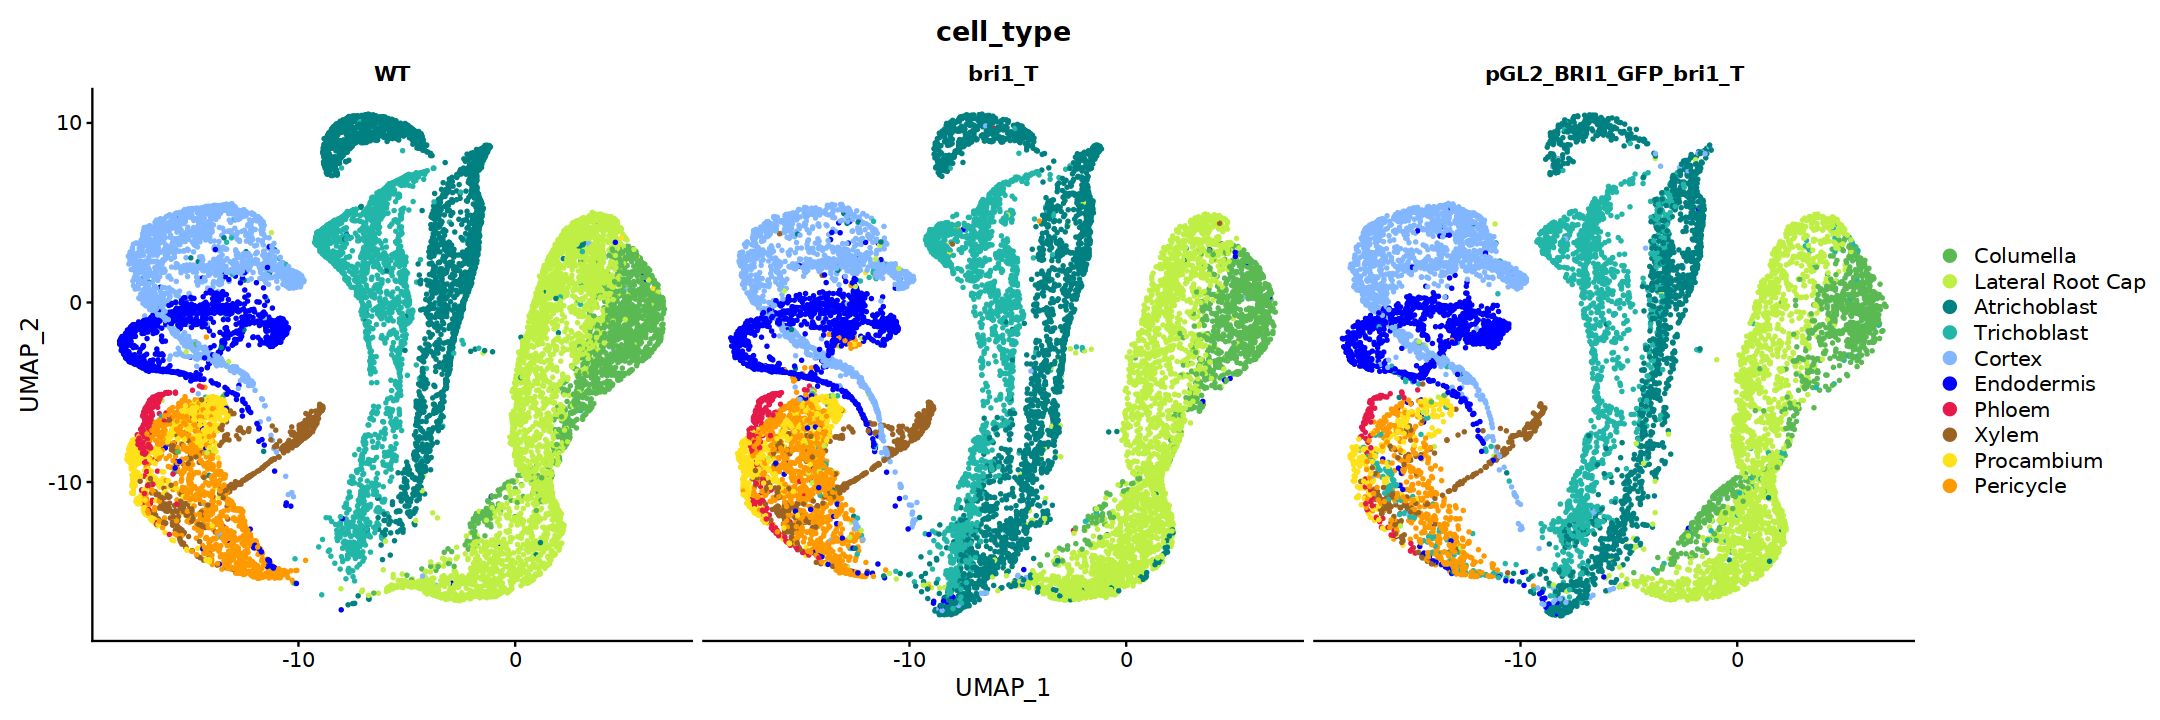

In [36]:
options(repr.plot.width=18, repr.plot.height=6)
(Celltype_umap <- DimPlot(integrated.de, 
                      reduction = "umap", 
                      group.by = "cell_type", 
                      cols = color, split.by = 'genotype', 
                      ncol=3, 
                      pt.size = 0.5))

ggsave("../output/GL2/Cell_type_umap_square.pdf", width=18.3, height=6)

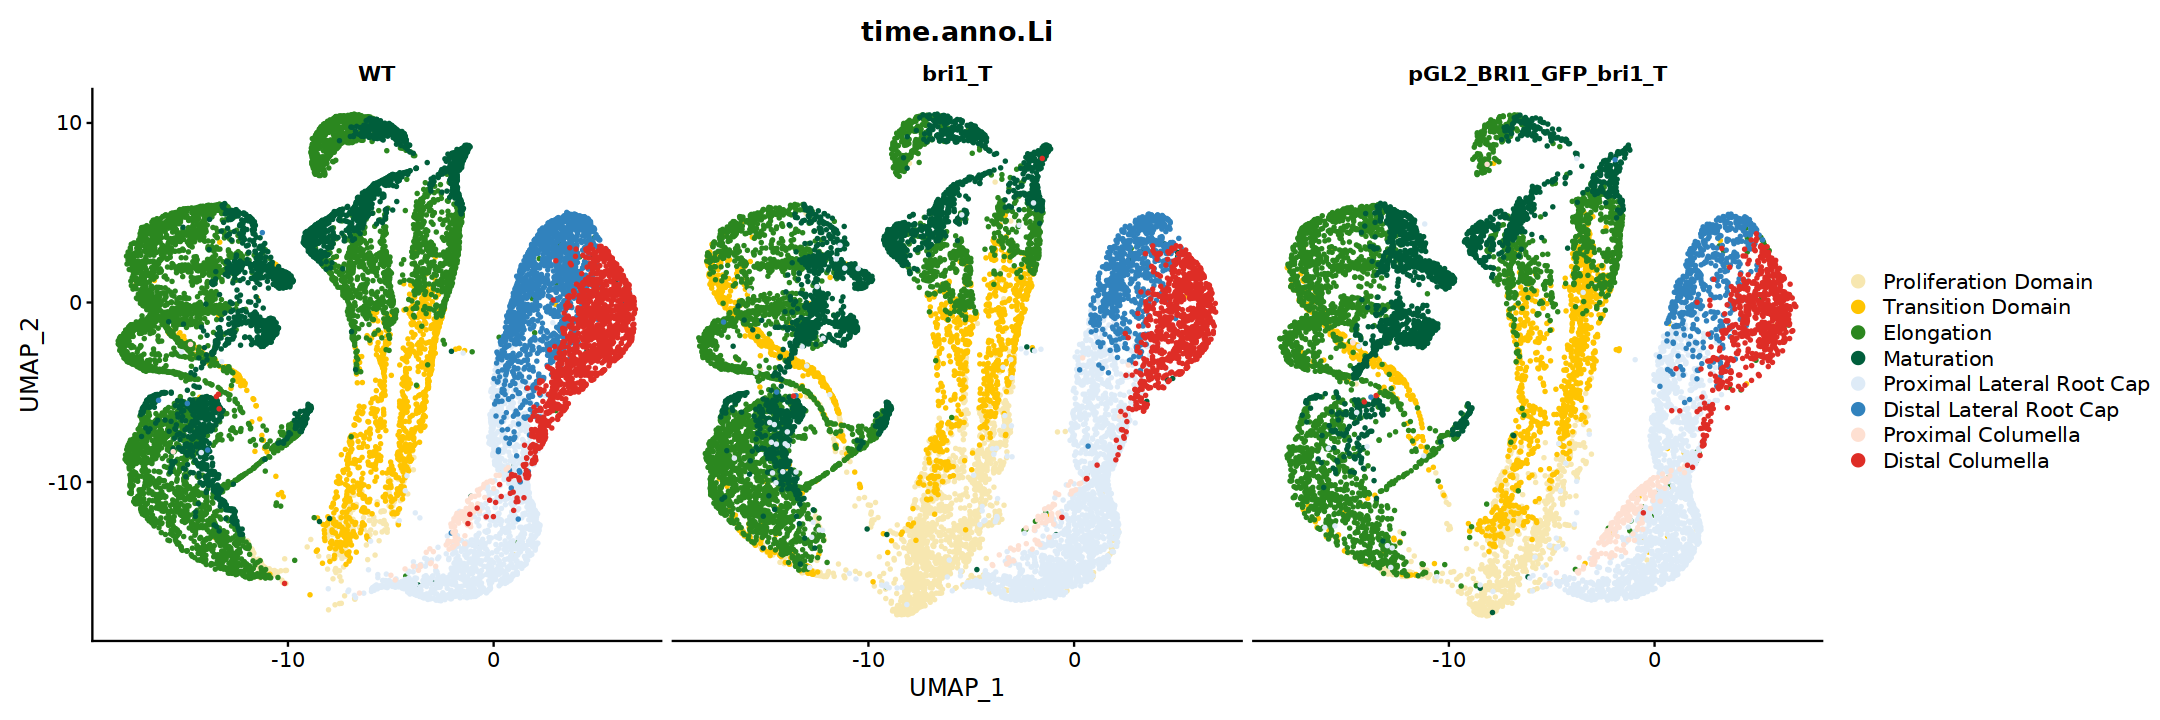

In [37]:
options(repr.plot.width=18, repr.plot.height=6)
DimPlot(integrated.de, 
        group.by = "time.anno.Li", 
                      split.by = 'genotype', 
        order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26'),
        ncol=3, 
        pt.size = 0.5)
ggsave("../output/GL2/Dev_stage_umap_square.pdf", width=18.3, height=6)

Warning message in FeaturePlot(integrated.de, features = "GL2-BRI1-GFP", split.by = "genotype", :
“All cells have the same value (0) of GL2-BRI1-GFP.”


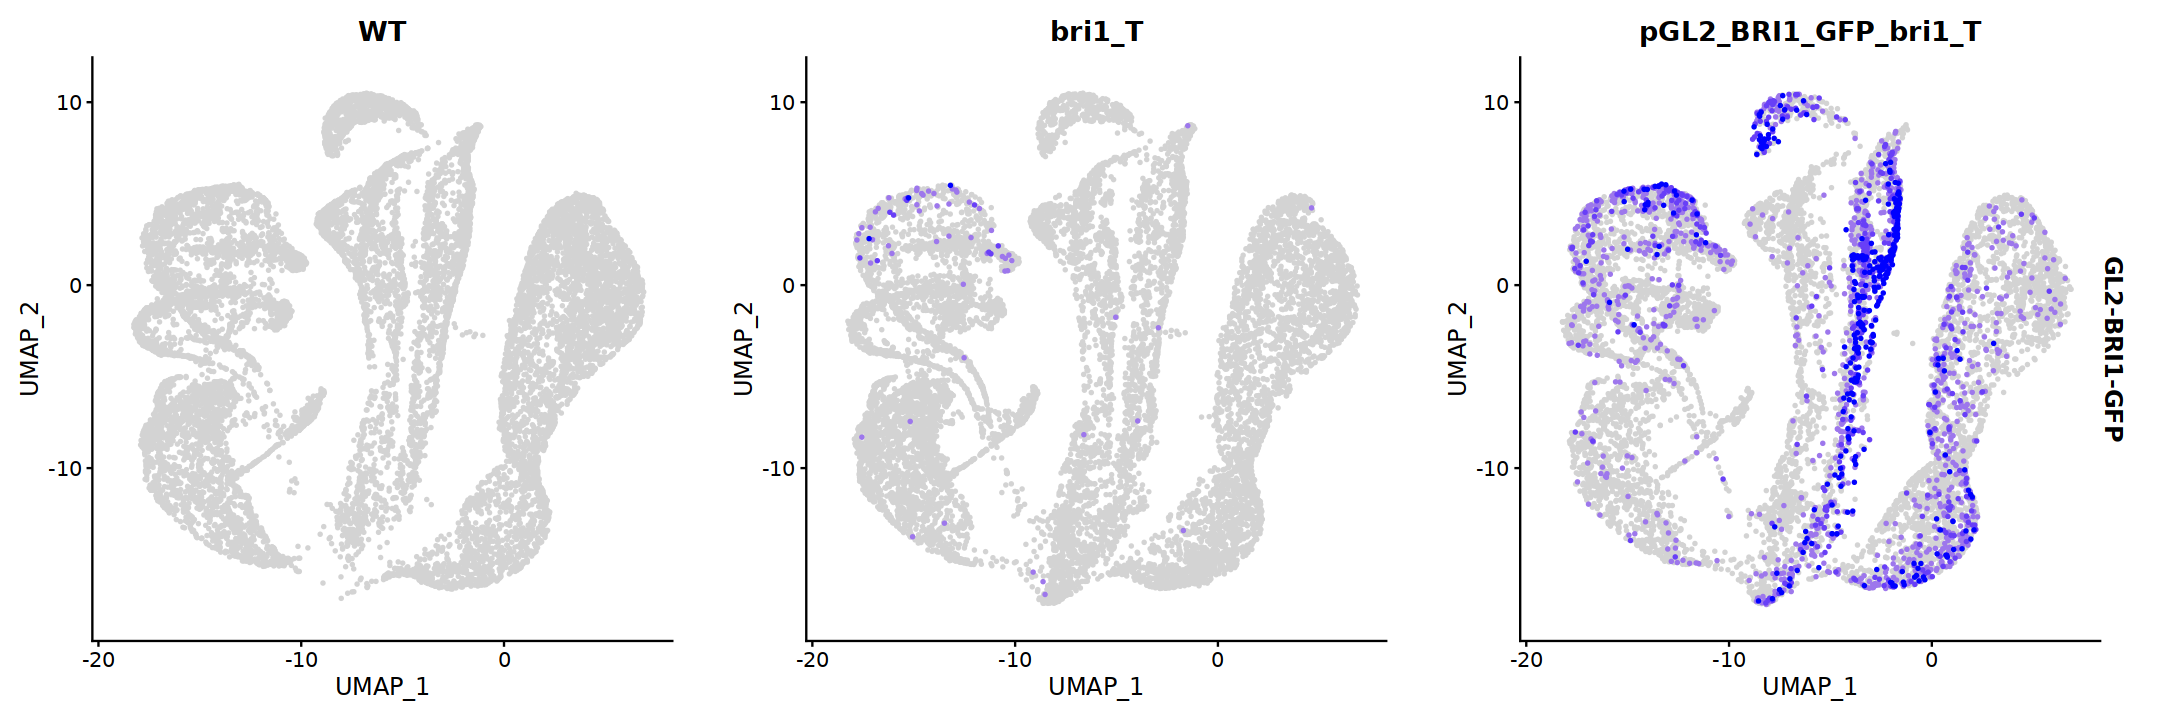

In [38]:
options(repr.plot.width = 18, repr.plot.height = 6)

DefaultAssay(integrated.de) <- "SCT"
# expression of the transgene
(BRI1_UMAP <- FeaturePlot(integrated.de, features="GL2-BRI1-GFP", split.by = "genotype", order=T, max.cutoff = "q90", pt.size = 0.5))

ggsave("../output/GL2/pGL2_BRI1-GFP_expression.pdf", width=18.3, height=6)

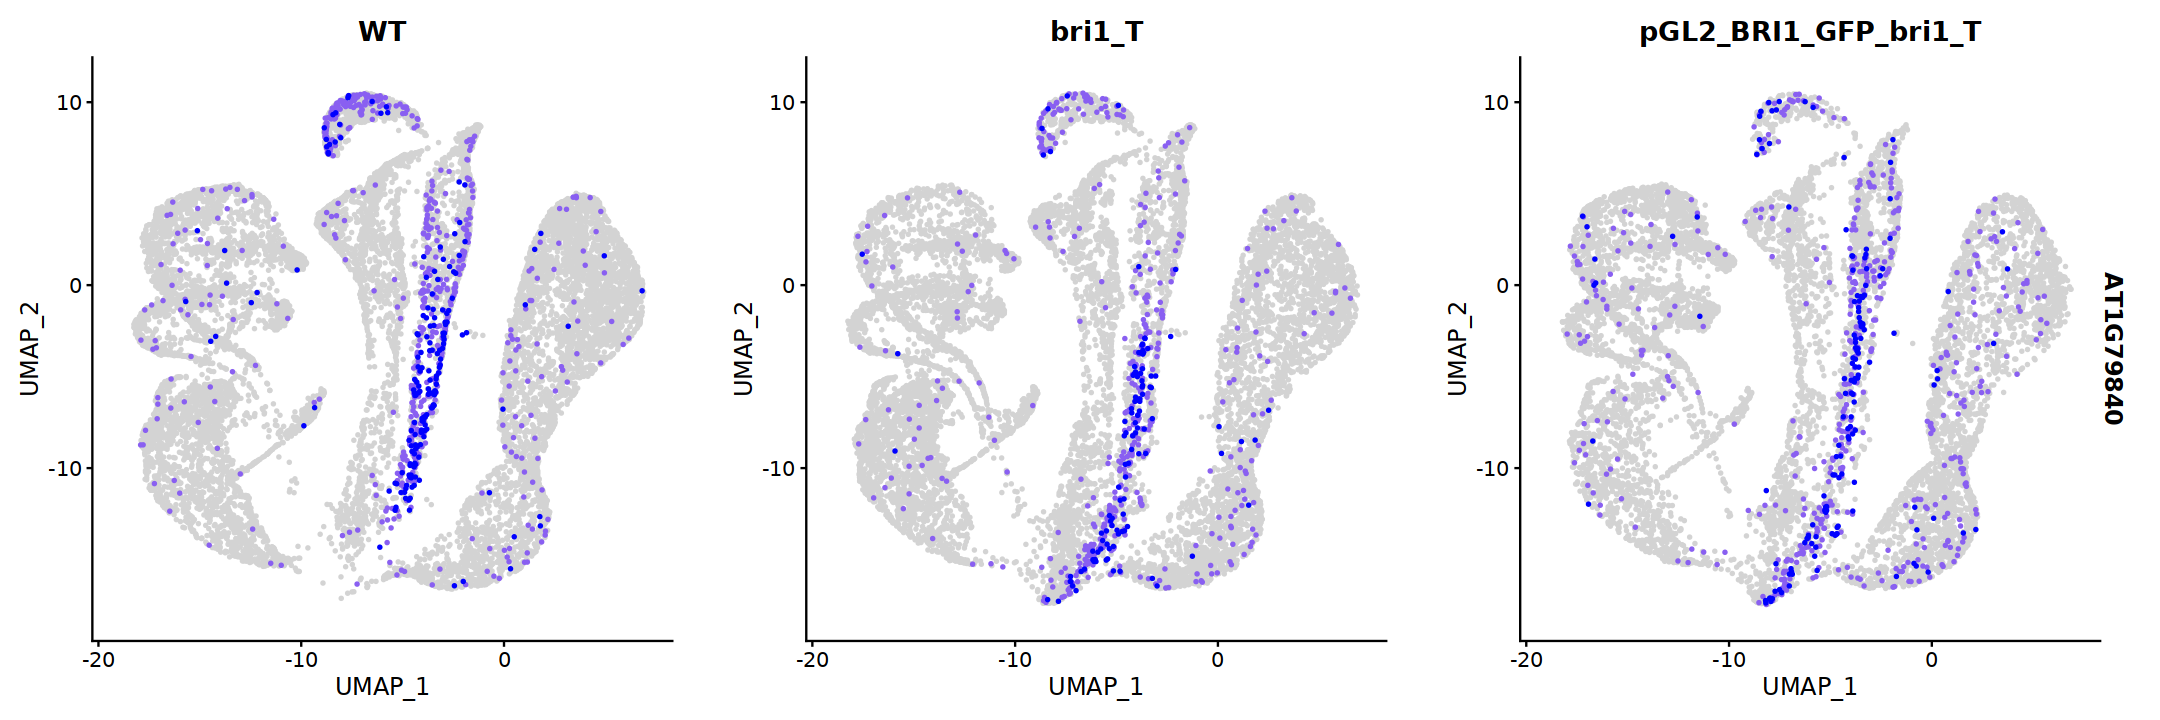

In [39]:
# expression of GL2
(GL2_UMAP <- FeaturePlot(integrated.de, features="AT1G79840", split.by = "genotype", order=T, max.cutoff = "q90", pt.size = 0.5))

ggsave("../output/GL2/GL2-AT1G79840_expression.pdf", width=18.3, height=6)

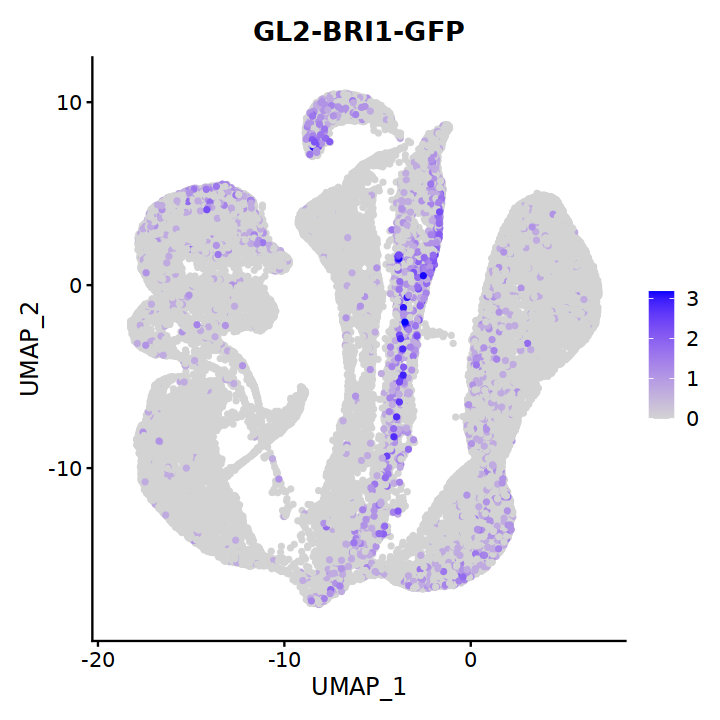

In [40]:
# save legend as PDF and update manually 
options(repr.plot.width = 6, repr.plot.height = 6)


FeaturePlot(integrated.de, reduction = "umap", features = "GL2-BRI1-GFP", pt.size=1)
ggsave("../output/GL2/UMAP_blue_legend.pdf", width=6, height=6)